# Multiple imputation

_Prepared for MLDS Research Project (MATH70105)_

## Contents

[1. Introduction](#introduction)

[2. Complete case analysis](#complete_case_analysis)

[3. Mean imputation](#mean_imputation)

[4. Multiple imputation](#multiple_imputation)

[5. Conclusion](#conclusion)

[References](#references)

<a class="anchor" id="introduction"></a>
## Introduction

In many applications of machine learning tasks, including supervised and unsupervised learning, the algorithms have been designed under the assumption that all the necessary information used in model training (i.e., the independent and dependent variables) should be complete for all observations. In practice, this is unlikely to hold true due the prevalent problem of missing data, which refers to a phenomenon in which some (or all) information related to a particular set of observations are not recorded, thereby preventing any users of the data from using this information ([Kang 2013](#Kang13)).

As data missingness could lead to increased bias and reduced statistical power ([Kang 2013](#Kang13), [Graham 2009](#Graham09)), appropriate strategies to handle missing data are needed. In this notebook, we will investigate several tools that can be used to handle missing data, starting with simpler approaches such as complete case analysis and mean imputation ([Van Buuren 2018](#Van18)). In the later part of this notebook, we will present a strategy known as multiple imputation ([Rubin 2004](#Rubin04)), which provides a more sophisticated yet flexible framework to handle various types of missing data, including non-continuous data.

To demonstrate these approaches, we use the `airquality` dataset, which is available in standard statistical softwares including R. This data set contains daily air quality measurements in New York between May and September 1973 ([Chambers et al 1983](#Chambers83)). For the purpose of demonstration in this notebook, the data set has been stored in a CSV file.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from matplotlib import cm

In [2]:
# Load sample data
data = pd.read_csv("data/airquality.csv", index_col=0)
print("Dimension of original data: {}".format(data.shape))

Dimension of original data: (153, 6)


In [3]:
# Look at first few rows
data.head()

,Ozone,Solar.R,Wind,Temp,Month,Day
1,41.0,190.0,7.4,67,5,1
2,36.0,118.0,8.0,72,5,2
3,12.0,149.0,12.6,74,5,3
4,18.0,313.0,11.5,62,5,4
5,NaN,NaN,14.3,56,5,5


In [4]:
# Count number of missing values in each column
data.isna().sum()

Ozone      37
Solar.R     7
Wind        0
Temp        0
Month       0
Day         0
dtype: int64

This data set contains six variables, with two of them (`Ozone` and `Solar.R`) having missing data. For the purpose of this demonstration, we will drop the columns `Month` and `Day`, which are not continuous variables. This leaves us with four continuous variables, two of them having missing values.

In [5]:
data = data.drop(["Month", "Day"], axis=1)

In [6]:
# Look at the "truncated" data
data.head()

,Ozone,Solar.R,Wind,Temp
1,41.0,190.0,7.4,67
2,36.0,118.0,8.0,72
3,12.0,149.0,12.6,74
4,18.0,313.0,11.5,62
5,NaN,NaN,14.3,56


<a class="anchor" id="complete_case_analysis"></a>
## Complete case analysis

In this section, we will start our discussion around missing data handling by looking at the most simplistic strategy known as "complete case analysis". As the name suggests, it involves removing observations for which any of the relevant variables are missing, thereby reducing the sample size. Many research studies across different application areas have been leveraging this approach, including clinical trials ([Wood et al 2004](#Wood04), [Powney et al 2014](#Powney14), [Díaz-Ordaz et al 2014](#Diaz14), [Akl et al 2015](#Akl15)) and epidemiology ([Klebanoff and Cole 2008](#Klebanoff08), [Karahalios 2012](#Karahalios12)). This can be easily done in Python, for example by using the method `.dropna()` in a Pandas data frame.

In [7]:
# Drop observations with missing values
data_complete = data.dropna()
print("Dimension of complete case data: {}".format(data_complete.shape))

Dimension of complete case data: (111, 4)


In [8]:
# The following code shows that the new data frame does not have any missing data
data_complete.isna().sum()

Ozone      0
Solar.R    0
Wind       0
Temp       0
dtype: int64

While the approach may seem attractive due to its simplicity, it can lead to a reduced statistical power due to lower sample size and also exacerbate bias. To demonstrate this, we look at the characteristics of the original data and the "complete case" data.

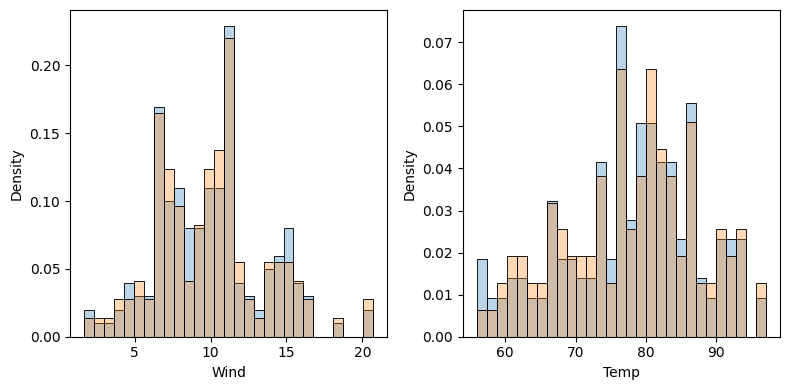

In [9]:
# We will investigate the univariate distribution of Wind and Temp in the original
# and complete case data
fig0, axs = plt.subplots(figsize=(8, 4), ncols=2, nrows=1)
wind_bins = np.linspace(data["Wind"].min(), data["Wind"].max(), 30)
sns.histplot(data=data["Wind"], ax=axs[0], stat="density", 
             alpha=0.3, bins=wind_bins)
sns.histplot(data=data_complete["Wind"], ax=axs[0], stat="density", 
             alpha=0.3, bins=wind_bins)
temp_bins = np.linspace(data["Temp"].min(), data["Temp"].max(), 30)
sns.histplot(data=data["Temp"], ax=axs[1], stat="density", 
             alpha=0.3, bins=temp_bins)
sns.histplot(data=data_complete["Temp"], ax=axs[1], stat="density", 
             alpha=0.3, bins=temp_bins)

fig0.tight_layout()

In general, complete case analysis can be considered if the data is missing completely at random (MCAR), which is not a realistic assumption for most real-world applications. On the other hand, imputation strategies are designed using a milder assumption that the data is missing at random (MAR), i.e., the missingness of a particular variable can be explained using other variables in the data ([Van Buuren 2018](#Van18)).

<a class="anchor" id="mean_imputation"></a>
## Mean imputation

Out of all the imputation strategies, mean imputation can be considered as one of the simplest approaches. Assuming a continuous variable (for non-continuous variables, mode imputation may be a viable alternative), missing values can be imputed using the sample mean calculated from the observed data.

In [10]:
# Calculate the sample mean
data.mean()

Ozone       42.129310
Solar.R    185.931507
Wind         9.957516
Temp        77.882353
dtype: float64

In [11]:
# Impute using the mean
data_meanimpute = data.fillna(data.mean())

In [12]:
# Demonstrate that the sample mean is preserved from the mean imputation
data_meanimpute.mean()

Ozone       42.129310
Solar.R    185.931507
Wind         9.957516
Temp        77.882353
dtype: float64

While it might seem attractive to perform mean imputation as it preserves the sample mean, it distorts the original data distribution, as seen from the following visualisation.

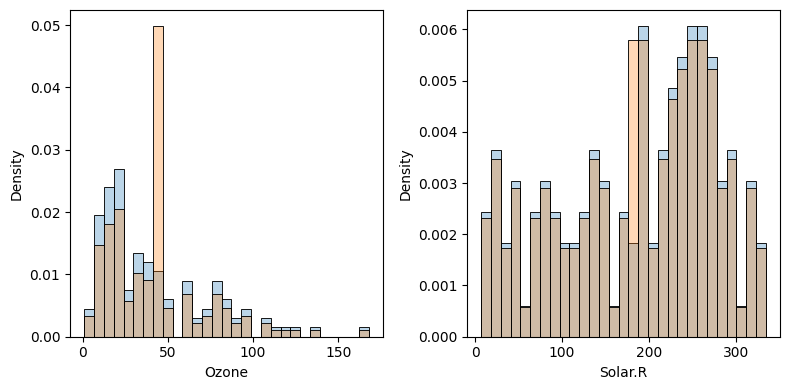

In [13]:
# We will investigate the univariate distribution of Ozone and Solar.R in the original
# and complete case data
fig1, axs = plt.subplots(figsize=(8, 4), ncols=2, nrows=1)
ozone_bins = np.linspace(data["Ozone"].min(), data["Ozone"].max(), 30)
sns.histplot(data=data["Ozone"], ax=axs[0], stat="density", 
             alpha=0.3, bins=ozone_bins)
sns.histplot(data=data_meanimpute["Ozone"], ax=axs[0], stat="density", 
             alpha=0.3, bins=ozone_bins)
solar_bins = np.linspace(data["Solar.R"].min(), data["Solar.R"].max(), 30)
sns.histplot(data=data["Solar.R"], ax=axs[1], stat="density", 
             alpha=0.3, bins=solar_bins)
sns.histplot(data=data_meanimpute["Solar.R"], ax=axs[1], stat="density", 
             alpha=0.3, bins=solar_bins)

fig1.tight_layout()

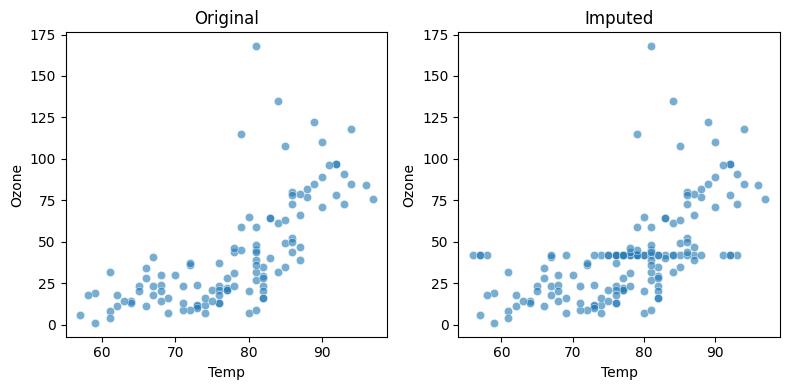

In [14]:
# To further demonstrate this, we generate a scatter plot between Ozone and Temp
fig2, axs = plt.subplots(figsize=(8, 4), ncols=2, nrows=1)
sns.scatterplot(data=data, x="Temp", y="Ozone", alpha=0.6, ax=axs[0])
sns.scatterplot(data=data_meanimpute, x="Temp", y="Ozone", alpha=0.6, ax=axs[1])
axs[0].set_title("Original")
axs[1].set_title("Imputed")

fig2.tight_layout()

Despite its simplicity, mean imputation leads to a distorted data distribution, and thus may exacerbate bias and should generally be avoided ([Van Buuren 2018](#Van18)). The impact of mean imputation becomes increasing apparent with higher rate of missingness and sample size.

<a class="anchor" id="multiple_imputation"></a>
## Multiple imputation

A more sophisticated alternative that has been presented in the literature is the regression imputation, which incorporates the knowledge of other variables in the data that may inform the value of the missing variable. While this provides an unbiased estimate for correctly specified models, it could still distort the correlations between variables, which is not desirable in machine learning tasks as it could introduce spurious correlations ([Van Buuren 2018](#Van18)).

Furthermore, it fails to account for the uncertainty around the imputation, as it produces a point estimate for the missing value. As such, refinements such as the stochastic regression imputation have been introduced to mitigate this problem. However, this is still not sufficient as the final imputed data still takes a point estimate of the imputed value, thereby underestimating the standard errors ([Van Buuren 2018](#Van18)).

Multiple imputation is a framework proposed by [Rubin 2004](#Rubin04) to tackle the limitations of these methods. It constructs multiple imputed data sets, each representing a plausible version of the imputed data, which are then used to calculate the estimand of interest (e.g., odds ratio) before they are pooled across all data sets. The multiple imputation framework can be illustrated by the following figure ([Lo et al 2019](#Lo19)).

<img src="figures/MultipleImputation.png" alt="Multiple imputation" style="width: 400px;"/>
<center>Multiple imputation generally consists of 3 main steps: (1) Imputation, (2) Analysis, (3) Pooling</center>

In practice, multiple imputation is a very flexible framework as it does not restrict the method that can be used in the imputation step, as long as the imputation method sufficiently accounts for the uncertainty from the imputation. As a result, it can also be applied on a data set which contains non-continuous (e.g., categorical) variable(s). A commonly used suite of tools for multiple imputation is the `mice` package in R, which implements a multivariate imputation by chained equations (MICE). This approach, equivalent to Gibbs sampling in Bayesian statistics, is typically used as the predictors for a given variable may also contain missing values ([Van Buuren and Groothuis-Oudshoorn 2011](#Van11)).

At the time of writing, there is no equivalent library in Python that offers extensive tools for multiple imputation in a way that `mice` does in R. As such, the goal of this notebook is to demonstrate how a particular choice of multiple imputation strategy can be implemented in Python. Specifically, we will implement the following:
1. Initialisation of the algorithm using random sampling imputation
2. Performing imputation using predictive mean matching, assuming Bayesian normal linear model for continuous variables (the exact steps are described in Algorithms 3.1 and 3.3 of [Van Buuren 2018](#Van18))
3. Implement multivariate imputation by chained equations (MICE), which assumes a fully conditional specification (i.e., each variable is predicted using all the remaining variables)

In [15]:
def ImputeRandomSample(data, seed=None):
    """
    Impute missing values using one of the observed values for a given variable 
    (univariate imputation).
    This function iterates over all columns in a data frame and imputes as necessary.
    
    Parameters
    ----------
    data : Pandas DataFrame
        Data frame to be imputed
    seed : None, optional
        Random seed for reproducibility
    
    Returns
    -------
    Pandas DataFrame
        Imputed data frame
    """
    # Copy data frame
    imp = data.copy()
    
    # Set random seed for reproducibility
    if seed is not None:
        np.random.seed(seed)
    
    # Iterate over all variables in the data frame
    for c in data.columns:
        # Find rows to be imputed and number of missing observations
        mr = data[c].isna()
        n = mr.sum()
        
        # Collect observed data for sampling
        obs = data[c].dropna().values
        
        # Impute using random samples
        # We assume that the data is not fully missing but only partially
        imp.loc[mr, c] = np.random.choice(obs, size=n, replace=True)
        
    return imp

In [16]:
# To test the function above, we run the following code snippet which should demonstrate
# that the number of unique values in the variable Ozone is retained even after imputation

print("Number of unique values in Ozone before imputation: {}".format(
    data["Ozone"].nunique()))
print("Number of unique values in Ozone after imputation: {}".format(
    ImputeRandomSample(data)["Ozone"].nunique()))

Number of unique values in Ozone before imputation: 67
Number of unique values in Ozone after imputation: 67


The function below implements a single imputation using predictive mean matching (PMM) ([Van Buuren 2018](#Van18)), which builds its idea from the original regression imputation by:
1. Incorporating uncertainty in the prediction (assuming Gaussian noise)
2. Incorporating uncertainty in the regression estimates (using the posterior distribution)
3. Imputation by selecting from a donor set, which represents actual observations determined by the nearest neighbours according to the regression model

In [17]:
# The following function performs single (not multiple yet) imputation using PMM
# which will act as the building block for the MICE implementation later on

def ImputePMM(data, missingflag, d=5, k=1e-5, seed=None):
    """
    Perform imputation using the predictive mean matching (PMM) method, 
    assuming all variables are continuous and can be modelled using the 
    Bayesian linear model.
    
    Parameters
    ----------
    data : Pandas DataFrame
        Data frame to be imputed
    missingflag : Pandas DataFrame
        A boolean data frame with the exact same dimension as `data`, with an
        indicator that shows if a given observation and variable is missing in
        `data`
    d : int, optional
        Number of donors in the donor set (default = 5)
    k : float, optional
        Ridge parameter for numerical stability (default = 1e-5)
    seed : None, optional
        Random seed
    
    Returns
    -------
    Pandas DataFrame
        Imputed data frame
    """
    # Set random seed
    if seed is not None:
        np.random.seed(seed)
    
    # Iterate over all columns
    for i, c in enumerate(data.columns):
        # Separate out variable to be imputed and predictors - with their respective
        # flags
        y = data[c]
        yflag = missingflag[c]
        X = data.drop(c, axis=1)
        Xflag = missingflag.drop(c, axis=1)
        
        # Skip if no missing value
        if yflag.sum() == 0:
            continue
        
        # Separate out observed and missing
        Xobs = X[~yflag].values
        Xmis = X[yflag].values
        yobs = y[~yflag].values
        ymis = y[yflag].values
        
        # Calculate regression weights (Algorithm 3.1)
        S = np.transpose(Xobs) @ Xobs
        V = np.linalg.inv(S + k * np.diag(np.diag(S)))
        bhat = V @ np.transpose(Xobs) @ yobs
        
        # Calculate noise variance
        df = len(yobs) - Xobs.shape[1]
        gdot = np.random.chisquare(df)
        res = yobs - Xobs @ bhat
        sigdot = np.sqrt(np.transpose(res) @ res / gdot)
        
        # Draw beta from the posterior distribution
        z1 = np.random.normal(size=Xobs.shape[1])
        bdot = bhat + sigdot * z1 @ np.linalg.cholesky(V)
        
        # Calculate the imputed values and overwrite data matrix
        # NOTE: This is the Bayesian linear model approach, not PMM
        #z2 = np.random.normal(size=len(ymis))
        #yimp = Xmis @ bdot + z2 * sigdot
        #data.loc[yflag, c] = yimp
        
        # Calculate distances
        eta = np.subtract.outer(np.dot(Xobs, bhat).ravel(), np.dot(Xmis, bdot).ravel())
        eta = np.abs(eta)
        
        # Identify donor sets for each missing value
        ind = np.argsort(eta, axis=0)
        donorind = ind[:d, :]
        
        # Draw random donor for each missing value
        selectedind = np.random.randint(0, d, size=len(ymis))
        selecteddonorind = np.diag(donorind[np.ix_(selectedind, np.arange(len(ymis)))])
        yimp = yobs[selecteddonorind]
        
        # Overwrite data matrix
        data.loc[yflag, c] = yimp

    return data

We will now use the functions above to implement the MICE algorithm using predictive mean matching (PMM).

In [18]:
# Helper function to calculate statistics of imputed data
def getImputedStats(data, missingflag):
    # Initialize arrays for mean and SD
    mu = np.zeros(data.shape[1])
    sigma = np.zeros(data.shape[1])
    
    for i, c in enumerate(data.columns):
        # Extract missing data
        miss = data.loc[missingflag[c], c]
        
        # Get statistics
        mu[i] = miss.mean()
        sigma[i] = miss.std(ddof=1)
    
    return mu, sigma

# Main function for MICE using PMM
def MICEPMM(data, m=10, maxit=5, d=5, k=1e-5, seed=123):
    """
    Implement multivariate imputation by chained equations (MICE) using 
    predictive mean matching (PMM) method. This function assumes that all
    variables are continuous and can be modelled using a Bayesian linear model.
    Furthermore, it assumes a fully conditional specification (FCS), which makes
    the original MICE framework.
    
    Parameters
    ----------
    data : Pandas DataFrame
        Data frame to be imputed
    m : int, optional
        Number of multiply imputed data to be generated (default = 10)
    maxit : int, optional
        Maximum number of iterations for the MICE algorithm (default = 5)
    d : int, optional
        Number of donors in the donor set (default = 5)
    k : float, optional
        Ridge parameter for numerical stability (default = 1e-5)
    seed : int, optional
        Random seed
    
    Returns
    -------
    dict
        Python dictionary with the imputed data (`imp`), missing data flag (`missingflag`),
        and the chain statistics (`chainmean` and `chainstd`)
    """
    # Set random seed
    if seed is not None:
        np.random.seed(seed)

    # Create flags for missing value
    missingflag = data.isna()
    
    # Make m copies of the data
    imp = []
    for _ in range(m):
        # Initialize using random sample
        imp.append(ImputeRandomSample(data))
    
    # Initialize chain statistics
    chainmean = np.empty((data.shape[1], m, maxit+1))
    chainstd = np.empty((data.shape[1], m, maxit+1))
    for i in range(m):
        chainmean[:, i, 0], chainstd[:, i, 0] = getImputedStats(imp[i], missingflag)
    
    # Iterate over maxit
    for j in tqdm(range(maxit)):
        #print("Iteration {}".format(j))
        
        for i in range(m):
            # Impute using PMM
            imp[i] = ImputePMM(imp[i], missingflag, d=d, k=k)
        
            # Calculate updated chain statistics
            chainmean[:, i, j+1], chainstd[:, i, j+1] = getImputedStats(imp[i], missingflag)
    
    # Return multiply imputed data and chain statistics
    res = {
        "imp": imp,
        "missingflag": missingflag,
        "chainmean": chainmean,
        "chainstd": chainstd
    }
    return res

We will now apply our MICE implementation on the `airquality` data set, with 10 sets of imputed data, 5 iterations, and a donor set size of 5.

In [19]:
# Once we have defined the functions, implement MICE on the airquality data
res = MICEPMM(data)

100%|█████████████████████████████████| 5/5 [00:00<00:00, 12.28it/s]


Once we obtain the multiply imputed data, we can use the following function to retrieve the imputed data for a given variable.

In [20]:
# Helper function to present imputed value across different imputations
def getImputedData(res, colname):
    """
    Helper function to get a data frame of imputed values for a given variable
    
    Parameters
    ----------
    res : dict
        Python dictionary returned by `MICEPMM`
    colname : str
        Variable for which the imputed data is to be shown
    
    Returns
    -------
    Pandas DataFrame
        Data frame showing observations with missing data only. Each column represents
        the output from each imputation model
    """
    # Retrieve relevant data
    implist, missingflag = res["imp"], res["missingflag"]
    
    # Extract relevant missing flag
    yflag = missingflag[colname]
    
    # Iterate over all imputed data
    impcombined = []
    for i, data in enumerate(implist):
        # Extract imputed values
        data = data.loc[yflag]
        data = data.rename(columns={colname: colname + str(i)})
        impcombined.append(data[colname + str(i)])
    
    impcombined = pd.concat(impcombined, axis=1)
    
    return impcombined

In [21]:
# Retrieve imputed data for the variable Ozone
impozone = getImputedData(res, "Ozone")
impozone

,Ozone0,Ozone1,Ozone2,Ozone3,Ozone4,Ozone5,Ozone6,Ozone7,Ozone8,Ozone9
5,23.0,23.0,23.0,32.0,32.0,23.0,6.0,19.0,32.0,32.0
10,21.0,35.0,16.0,71.0,44.0,63.0,28.0,14.0,36.0,47.0
25,6.0,19.0,37.0,14.0,8.0,37.0,14.0,18.0,19.0,9.0
26,32.0,30.0,9.0,1.0,23.0,11.0,6.0,9.0,23.0,22.0
27,21.0,10.0,4.0,9.0,7.0,16.0,19.0,21.0,14.0,30.0
32,59.0,122.0,32.0,115.0,46.0,108.0,32.0,30.0,37.0,77.0
33,65.0,85.0,24.0,47.0,30.0,23.0,18.0,36.0,18.0,96.0
34,19.0,14.0,19.0,32.0,32.0,4.0,37.0,19.0,1.0,52.0
35,59.0,64.0,35.0,32.0,78.0,37.0,9.0,30.0,39.0,61.0
36,49.0,97.0,78.0,28.0,108.0,80.0,13.0,39.0,108.0,77.0


One of the ways we can assess the performance and convergence of the algorithm is by using the trace plot of the chain statistics, which comprises the mean and standard deviation of the imputed values for a given variable over iterations. This can be visualised using the following helper function.

In [22]:
# Helper function to visualise the chain statistics
def ChainStatsViz(res, maxvar=3):
    """
    Constructs a trace plot of chain statistics based on the `MICEPMM` output
    
    Parameters
    ----------
    res : dict
        Python dictionary returned by `MICEPMM`
    maxvar : int, optional
        Maximum number of variables to be visualized (default = 3). Note that only
        variables with missing data will be shown
    
    Returns
    -------
    matplotlib.pyplot.figure
        Figure showing the trace plots
    """
    # Retrieve chain mean and standard deviation
    chainmean, chainstd = res["chainmean"], res["chainstd"]
    
    # Pick first maxvar variables with missing data
    allvars = pd.Series(data.columns.values)
    missingvars = data.columns[res["missingflag"].sum() > 0]
    if len(missingvars) < maxvar:
        maxvar = len(missingvars)
    else:
        missingvars = missingvars[:maxvar]
    missingvarsind = allvars[allvars.isin(missingvars)].index
    
    # Get number of imputed data
    m = len(res["imp"])
    
    # Placeholder for plotting
    fig, axs = plt.subplots(figsize=(8, maxvar*3), ncols=2, nrows=maxvar, 
                            sharex=True)
    cmap = cm.get_cmap("jet", 10) # If m > 10, it will rotate back to start
    
    # Generate plot for each variable and imputation
    for i, idx in enumerate(missingvarsind):
        # Plot chain mean
        for j in range(m):
            axs[i, 0].plot(chainmean[i, j, :], color=cmap(j % 10), alpha=0.7)
        axs[i, 0].set_title("{}: mean".format(allvars[idx]))
        
        # Plot chain SD
        for j in range(m):
            axs[i, 1].plot(chainstd[i, j, :], color=cmap(j % 10), alpha=0.7)
        axs[i, 1].set_title("{}: SD".format(allvars[idx]))
    
    return fig

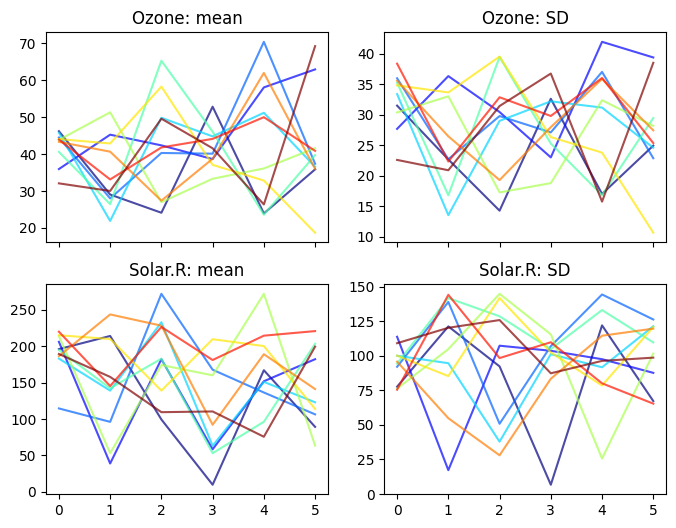

In [23]:
# Generate trace plot of chain statistics (Python)
fig3 = ChainStatsViz(res)

In practice, convergence is achieved when each stream of imputation (i.e., single imputed data getting updated over iterations) does not show clear trends against each other ([Van Buuren and Groothuis-Oudshoorn 2011](#Van11)), which seems to be the case in our example.

To better demonstrate the performance of our implementation, we will compare this with the original R implementation, which can be accessed in Python using the interface provided by `rpy2`.

In [24]:
# Benchmarking against R implementation (accessed using rpy2)
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from IPython.display import Image, display

In [25]:
# Load relevant R packages as objects
base = importr("base")
mice = importr("mice")

# Convert data frames into R objects
with localconverter(robjects.default_converter + pandas2ri.converter):
    r_df = robjects.conversion.py2rpy(data)

# Implement MICE
imp_r = mice.mice(r_df, m=10, maxit=5, method="pmm", seed=123)


 iter imp variable
  1   1  Ozone  Solar.R
  1   2  Ozone  Solar.R
  1   3  Ozone  Solar.R
  1   4  Ozone  Solar.R
  1   5  Ozone  Solar.R
  1   6  Ozone  Solar.R
  1   7  Ozone  Solar.R
  1   8  Ozone  Solar.R
  1   9  Ozone  Solar.R
  1   10  Ozone  Solar.R
  2   1  Ozone  Solar.R
  2   2  Ozone  Solar.R
  2   3  Ozone  Solar.R
  2   4  Ozone  Solar.R
  2   5  Ozone  Solar.R
  2   6  Ozone  Solar.R
  2   7  Ozone  Solar.R
  2   8  Ozone  Solar.R
  2   9  Ozone  Solar.R
  2   10  Ozone  Solar.R
  3   1  Ozone  Solar.R
  3   2  Ozone  Solar.R
  3   3  Ozone  Solar.R
  3   4  Ozone  Solar.R
  3   5  Ozone  Solar.R
  3   6  Ozone  Solar.R
  3   7  Ozone  Solar.R
  3   8  Ozone  Solar.R
  3   9  Ozone  Solar.R
  3   10  Ozone  Solar.R
  4   1  Ozone  Solar.R
  4   2  Ozone  Solar.R
  4   3  Ozone  Solar.R
  4   4  Ozone  Solar.R
  4   5  Ozone  Solar.R
  4   6  Ozone  Solar.R
  4   7  Ozone  Solar.R
  4   8  Ozone  Solar.R
  4   9  Ozone  Solar.R
  4   10  Ozone  Solar.R
  5   1  Ozone  

In [26]:
# Show the imputed output for Ozone
ozone_imp_r = imp_r.rx2("imp").rx2("Ozone")

with localconverter(robjects.default_converter + pandas2ri.converter):
    ozone_imp_df = robjects.conversion.rpy2py(ozone_imp_r)

In [27]:
ozone_imp_df

,1,2,3,4,5,6,7,8,9,10
5,1.0,37.0,14.0,18.0,18.0,1.0,19.0,19.0,19.0,8.0
10,41.0,44.0,14.0,41.0,27.0,41.0,16.0,44.0,21.0,16.0
25,14.0,18.0,19.0,6.0,18.0,14.0,18.0,6.0,6.0,6.0
26,11.0,9.0,37.0,18.0,37.0,37.0,11.0,1.0,37.0,4.0
27,32.0,20.0,28.0,11.0,18.0,9.0,4.0,32.0,19.0,18.0
32,23.0,32.0,32.0,37.0,16.0,32.0,71.0,46.0,32.0,7.0
33,65.0,29.0,23.0,18.0,30.0,18.0,20.0,59.0,65.0,23.0
34,7.0,13.0,11.0,28.0,9.0,37.0,9.0,23.0,28.0,18.0
35,28.0,59.0,32.0,46.0,46.0,59.0,115.0,35.0,40.0,71.0
36,40.0,39.0,71.0,115.0,35.0,49.0,66.0,49.0,108.0,49.0


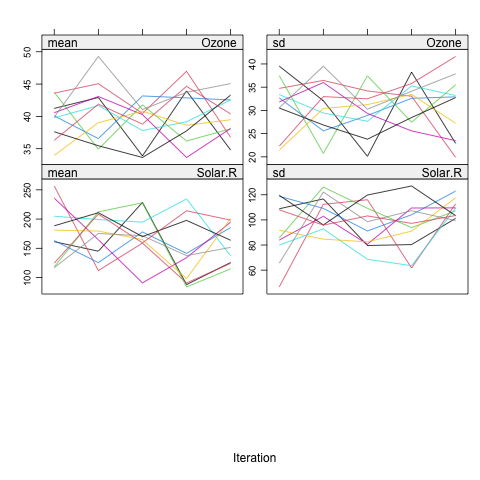

In [28]:
# Generate trace plot of chain statistics (R)
grdevices = importr("grDevices")

grdevices.png(file="figures/trace_plot_r.png")
p = mice.plot_mids(imp_r)
base.print(p)
grdevices.dev_off()

display(Image(filename="figures/trace_plot_r.png"))

While the R implementation does not produce the exact same set of imputed values, which could be driven from the fact that both softwares use a different random number generator, we could see that the chain statistics lies around a similar range of values between both implementations.

An alternative way to compare the two implementations is by constructing a line plot representing the minimum and maximum imputed value for a selected set of observations.

Text(0.5, 0.98, 'Ozone imputation')

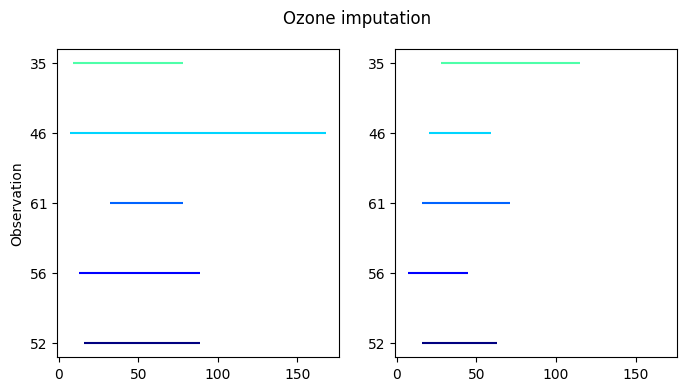

In [29]:
# For easier visualisation, we will generate a horizontal line plot demonstrating
# the range of imputed value for a given observation between the Python and R
# implementations
# We will focus on the variable Ozone

randomobs = np.random.choice(impozone.index, size=5, replace=False)
cmap = cm.get_cmap("jet", 10)

fig4, axs = plt.subplots(ncols=2, nrows=1, figsize=(8,4), sharex=True)
for i, idx in enumerate(randomobs):
    axs[0].hlines(i+1, impozone.loc[idx].min(), impozone.loc[idx].max(), color=cmap(i))
    axs[1].hlines(i+1, ozone_imp_df.loc[str(idx)].min(), ozone_imp_df.loc[str(idx)].max(), 
                  color=cmap(i))

axs[0].set_yticks(np.arange(1, 6))
axs[0].set_yticklabels(randomobs)
axs[1].set_yticks(np.arange(1, 6))
axs[1].set_yticklabels(randomobs)
axs[0].set_ylabel("Observation")
fig4.suptitle("Ozone imputation")

We can see that while both implementations do not produce the exact same range, they still reasonably overlap with each other!

<a class="anchor" id="conclusion"></a>
## Conclusion

We have shown using a simple example that multiple imputation can provide more nuances around the missing data without making a very strong assumption about how it came about. Methods such as predictive mean matching are more realistic than both complete case analysis and mean imputation, as it does not lead to a reduced sample size and also leverages other information available in the data to inform the imputation. Nonetheless, careful considerations are needed in selecting an appropriate imputation model and set of predictor variables, as MAR still assumes that the missingness should be fully explained using the predictor variables.

We have also shown that it is possible to implement the MICE algorithm in Python using the standard libraries such as NumPy and Pandas. While we are currently focusing on a simple implementation assuming a Bayesian linear model for continuous variables, it is possible to extend the algorithm to allow non-continuous variables, which are commonly encountered in a wide range of application areas.

Another aspect that is not investigated in this notebook but may warrant a further research is related to the downstream use of multiply imputed data. The algorithm was originally designed while assuming a finite number of statistical estimands (e.g., odds ratios), which works reasonably well for a generalized linear model (GLM). While several studies have suggested the use of advanced machine learning (ML) for imputation models within the multiple imputation framework ([Shah et al 2014](#Shah14), [Hong and Lynn 2020](#Hong20), [Laqueur et al 2022](#Laqueur22), [Wang et al 2022](#Wang22)), studies demonstrating the use of multiply imputed data in downstream advanced ML task remained surprisingly scarce ([Kim et al 2022](#Kim22)). With an increasing use of ML across application areas, it is important to consider how we can extend the idea of estimation and pooling in the context of a "black box" model.

<a class="anchor" id="references"></a>
## References

<a class="anchor" id="Kang13"></a>
* Kang, H., 2013. The prevention and handling of the missing data. *Korean journal of anesthesiology*, 64(5), pp.402-406.
<a class="anchor" id="Graham09"></a>
* Graham, J.W., 2009. Missing data analysis: Making it work in the real world. *Annual review of psychology*, 60, pp.549-576.
<a class="anchor" id="Van18"></a>
* Van Buuren, S., 2018. *Flexible imputation of missing data*. CRC press.
<a class="anchor" id="Rubin04"></a>
* Rubin, D.B., 2004. *Multiple imputation for nonresponse in surveys* (Vol. 81). John Wiley & Sons.
<a class="anchor" id="Chambers83"></a>
* Chambers, J.M., Cleveland, W.S., Kleiner, B. and Tukey, P.A., 1983. Graphical methods for data analysis. Wadsworth Int'l. *Group, Belmont, CA*.
<a class="anchor" id="Wood04"></a>
* Wood, A.M., White, I.R. and Thompson, S.G., 2004. Are missing outcome data adequately handled? A review of published randomized controlled trials in major medical journals. *Clinical trials*, 1(4), pp.368-376.
<a class="anchor" id="Powney14"></a>
* Powney, M., Williamson, P., Kirkham, J. and Kolamunnage-Dona, R., 2014. A review of the handling of missing longitudinal outcome data in clinical trials. *Trials*, 15(1), pp.1-11.
<a class="anchor" id="Diaz14"></a>
* Díaz-Ordaz, K., Kenward, M.G., Cohen, A., Coleman, C.L. and Eldridge, S., 2014. Are missing data adequately handled in cluster randomised trials? A systematic review and guidelines. *Clinical Trials*, 11(5), pp.590-600.
<a class="anchor" id="Akl15"></a>
* Akl, E.A., Shawwa, K., Kahale, L.A., Agoritsas, T., Brignardello-Petersen, R., Busse, J.W., Carrasco–Labra, A., Ebrahim, S., Johnston, B.C., Neumann, I. and Sola, I., 2015. Reporting missing participant data in randomised trials: systematic survey of the methodological literature and a proposed guide. *BMJ open*, 5(12), p.e008431.
<a class="anchor" id="Klebanoff08"></a>
* Klebanoff, M.A. and Cole, S.R., 2008. Use of multiple imputation in the epidemiologic literature. *American journal of epidemiology*, 168(4), pp.355-357.
<a class="anchor" id="Karahalios12"></a>
* Karahalios, A., Baglietto, L., Carlin, J.B., English, D.R. and Simpson, J.A., 2012. A review of the reporting and handling of missing data in cohort studies with repeated assessment of exposure measures. *BMC medical research methodology*, 12(1), pp.1-10.
<a class="anchor" id="Lo19"></a>
* Lo, A.W., Siah, K.W. and Wong, C.H., 2019. *Machine learning with statistical imputation for predicting drug approvals* (Vol. 60). SSRN.
<a class="anchor" id="Van11"></a>
* Van Buuren, S. and Groothuis-Oudshoorn, K., 2011. mice: Multivariate imputation by chained equations in R. *Journal of statistical software, 45*, pp.1-67.
<a class="anchor" id="Shah14"></a>
* Shah, A.D., Bartlett, J.W., Carpenter, J., Nicholas, O. and Hemingway, H., 2014. Comparison of random forest and parametric imputation models for imputing missing data using MICE: a CALIBER study. *American journal of epidemiology, 179*(6), pp.764-774.
<a class="anchor" id="Hong20"></a>
* Hong, S. and Lynn, H.S., 2020. Accuracy of random-forest-based imputation of missing data in the presence of non-normality, non-linearity, and interaction. *BMC medical research methodology, 20*(1), pp.1-12.
<a class="anchor" id="Laqueur22"></a>
* Laqueur, H.S., Shev, A.B. and Kagawa, R.M., 2022. SuperMICE: An ensemble machine learning approach to multiple imputation by chained equations. *American journal of epidemiology, 191*(3), pp.516-525.
<a class="anchor" id="Wang22"></a>
* Wang, H., Tang, J., Wu, M., Wang, X. and Zhang, T., 2022. Application of machine learning missing data imputation techniques in clinical decision making: taking the discharge assessment of patients with spontaneous supratentorial intracerebral hemorrhage as an example. *BMC Medical Informatics and Decision Making, 22*(1), pp.1-14.
<a class="anchor" id="Kim22"></a>
* Kim, H.R., Soh, H.Y., Kwak, M.T. and Han, S.H., 2022. Machine Learning and Multiple Imputation Approach to Predict Chlorophyll-a Concentration in the Coastal Zone of Korea. *Water, 14*(12), p.1862.